This notebook focuses on experiments with the T5-Small model, the chosen architecture for SMART goal generation. It encompasses the modeling process, evaluation on test data, and preparation of a sample dataset for external assessment. The notebook demonstrates the model's progression from fine-tuning to evaluation and sets the foundation for validating its performance through external feedback.


In [ ]:
!pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
 from google.colab import drive
 drive.mount('/content/drive')

Mounted at /content/drive


T5-Small Modeling
The script begins with fine-tuning the T5-Small model on the augmented dataset. This process tailors the pre-trained model to the specific task of transforming vague goals into SMART goals, aligning with the criteria of specificity, measurability, achievability, relevance, and time-bound attributes. The fine-tuning process ensures the model adapts to the nuances of the dataset while maintaining computational efficiency.

In [ ]:
import pandas as pd
import torch
from datasets import load_dataset,Dataset
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import T5Tokenizer, T5ForConditionalGeneration
import warnings
from peft import LoraConfig, get_peft_model, TaskType
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq

In [ ]:
# Load pre-split  cleaned datasets

train_data = pd.read_csv("/content/drive/My Drive/train_data_cleaned.csv")
val_data = pd.read_csv("/content/drive/My Drive/validation_data_cleaned.csv")
test_data = pd.read_csv("/content/drive/My Drive/test_data_cleaned.csv")

# Verify the sizes of each split
print(f"Training data: {len(train_data)} samples")
print(f"Validation data: {len(val_data)} samples")
print(f"Testing data: {len(test_data)} samples")

Training data: 3616 samples
Validation data: 452 samples
Testing data: 452 samples


In [ ]:
model_id = "t5-small"

tokenizer = T5Tokenizer.from_pretrained(model_id)
model = T5ForConditionalGeneration.from_pretrained(model_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
class SmartGoalDataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer, source_max_length=512, target_max_length=1024):
        self.data = data
        self.tokenizer = tokenizer
        self.source_max_length = source_max_length
        self.target_max_length = target_max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        augmented_vague_goal = str(self.data.iloc[idx]['Augmented Vague Goal'])
        smart_goal = str(self.data.iloc[idx]['SMART Goal'])

        source = self.tokenizer(
            " vague goal to SMART goal: " + augmented_vague_goal,
            max_length=self.source_max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        target = self.tokenizer(
            smart_goal,
            max_length=self.target_max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        return {
            "input_ids": source["input_ids"].squeeze(dim=0),
            "attention_mask": source["attention_mask"].squeeze(dim=0),
            "labels": target["input_ids"].squeeze(dim=0)
        }

In [ ]:
# Create datasets
train_dataset = SmartGoalDataset(train_data, tokenizer)
val_dataset = SmartGoalDataset(val_data, tokenizer)
test_dataset = SmartGoalDataset(test_data, tokenizer)

In [ ]:
# data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model, padding=True)

In [ ]:
# val_dataset[1]

In [ ]:
#label_pad_token_id = -100
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    #label_pad_token_id=label_pad_token_id,
)

In [ ]:
# Define training arguments
output_dir = "t5-small-chat"
training_args = Seq2SeqTrainingArguments(
    output_dir=output_dir,
    learning_rate=1e-3,
    num_train_epochs=3,
    logging_dir=f"{output_dir}/logs",
    logging_strategy="epoch",  # Logs after every epoch
    evaluation_strategy="epoch",  # Evaluates after every epoch
    save_strategy="epoch",  # Saves the model after every epoch
    eval_accumulation_steps=10,  # Optimizes memory for large datasets
    push_to_hub=False
)




/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)



In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/usr/local/lib/python3.10/dist-packages/transformers/data/data_collator.py:657: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,0.411400,0.269789
2,0.282100,0.242241
3,0.258000,0.232357


TrainOutput(global_step=1356, training_loss=0.3171523946576414, metrics={'train_runtime': 1812.9645, 'train_samples_per_second': 5.984, 'train_steps_per_second': 0.748, 'total_flos': 1468187862368256.0, 'train_loss': 0.3171523946576414, 'epoch': 3.0})

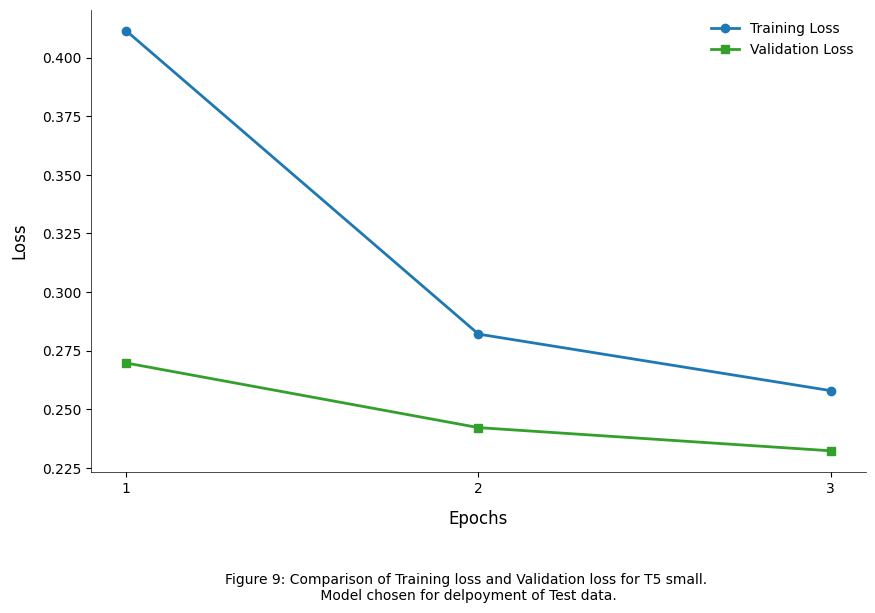

In [ ]:
import matplotlib.pyplot as plt

# Data for plotting
epochs = [1, 2, 3]
train_losses = [0.411400, 0.282100, 0.258000]
val_losses = [0.269789, 0.242241, 0.232357]

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot training and validation losses
ax.plot(epochs, train_losses, marker="o", label="Training Loss", color="#1F78B4", linewidth=2, markersize=6)
ax.plot(epochs, val_losses, marker="s", label="Validation Loss", color="#33A02C", linewidth=2, markersize=6)

# Add labels, legend, and ticks
ax.set_xticks(epochs)
ax.set_ylabel("Loss", fontsize=12, labelpad=10)
ax.set_xlabel("Epochs", fontsize=12, labelpad=10)
ax.legend(loc="upper right", fontsize=10, frameon=False)

# Minimalist style
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(0.5)
ax.spines["bottom"].set_linewidth(0.5)
ax.set_facecolor("white")

# Add caption below the chart
fig.text(
    0.5,
    -0.1,
    "Figure 9: Comparison of Training loss and Validation loss for T5 small.\n Model chosen for delpoyment of Test data.",
    wrap=True,
    horizontalalignment="center",
    fontsize=10,
)

# Save as High-Resolution File
plt.savefig(
      "/content/drive/My Drive/training_validation_loss_T5Small.png",
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.3,
)

# Display the chart
plt.show()


In [ ]:
model.save_pretrained("/content/drive/My Drive/t5_smart_goal_model")
tokenizer.save_pretrained("/content/drive/My Drive/t5_smart_goal_model")

('/content/drive/My Drive/t5_smart_goal_model/tokenizer_config.json',
 '/content/drive/My Drive/t5_smart_goal_model/special_tokens_map.json',
 '/content/drive/My Drive/t5_smart_goal_model/spiece.model',
 '/content/drive/My Drive/t5_smart_goal_model/added_tokens.json')

In [ ]:
!pip install -q bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.3 MB/s eta 0:00:00


In [ ]:
from bert_score import score as bert_score
from sentence_transformers import SentenceTransformer
from sentence_transformers import util


# Load the Sentence-BERT model
sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')  # Or another model of your choice


In [ ]:
# Paths to  T5 model
t5_model_path = "/content/drive/My Drive/t5_smart_goal_model"

In [ ]:
# Load  T5 model and tokenizer
model = T5ForConditionalGeneration.from_pretrained(t5_model_path)
tokenizer = T5Tokenizer.from_pretrained(t5_model_path)




In [ ]:
# Move model to the appropriate device
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [ ]:
# Create a DataLoader for validation dataset
from torch.utils.data import DataLoader
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

In [ ]:
# Helper function to calculate Perplexity
def calculate_perplexity(input_ids, model):
    with torch.no_grad():
        outputs = model(input_ids=input_ids, labels=input_ids)
        return torch.exp(outputs.loss).item()

In [ ]:
# Helper function for Faithfulness calculation
def calculate_faithfulness(input_text, generated_text):
    input_embedding = sbert_model.encode(input_text, convert_to_tensor=True)
    output_embedding = sbert_model.encode(generated_text, convert_to_tensor=True)
    return util.pytorch_cos_sim(input_embedding, output_embedding).item()

In [ ]:
# Evaluation function
def evaluate_model(model, tokenizer, model_name, data_loader, max_length=512, repetition_penalty=1.2, min_length=50):

    results_df = pd.DataFrame(columns=["Model", "Input", "Reference", "Output", "BERTScore", "Perplexity", "Faithfulness"])

    for batch_idx, batch in enumerate(data_loader):
        try:
            # Move batch data to device
            input_ids_batch = batch["input_ids"].to(device)
            attention_mask_batch = batch["attention_mask"].to(device)
            reference_ids = batch["labels"].to(device)

            # Generate outputs using the default greedy decoding
            output_ids_batch = model.generate(
                input_ids=input_ids_batch,
                attention_mask=attention_mask_batch,
                max_length=512,
                repetition_penalty=repetition_penalty,
                length_penalty=1.0,
                pad_token_id=tokenizer.pad_token_id
            )

            # Decode generated and reference texts
            input_texts = [tokenizer.decode(input_ids, skip_special_tokens=True) for input_ids in input_ids_batch]
            generated_texts = [tokenizer.decode(output, skip_special_tokens=True) for output in output_ids_batch]
            reference_texts = [tokenizer.decode(ref, skip_special_tokens=True) for ref in reference_ids]

            # Calculate metrics
            P, R, F1 = bert_score(generated_texts, reference_texts, lang="en", model_type="bert-base-uncased")
            faithfulness_scores = [calculate_faithfulness(ref, gen) for ref, gen in zip(reference_texts, generated_texts)]
            perplexities = [calculate_perplexity(ref.unsqueeze(0), model) for ref in reference_ids]

            # Append results
            for i in range(len(generated_texts)):
                results_df.loc[len(results_df)] = [
                    model_name,
                    input_texts[i],  # Use decoded input text
                    reference_texts[i],
                    generated_texts[i],
                    F1[i].item(),
                    perplexities[i],
                    faithfulness_scores[i]
                ]

        except Exception as e:
            print(f"Error processing batch {batch_idx}: {e}")
            continue

    # Save final results to CSV
    results_df.to_csv("/content/drive/My Drive/model_evaluation_T5_results_new.csv", index=False)
    print("Final results saved.")

# Run the evaluation
evaluate_model(
    model,
    tokenizer,
    "Default T5 Evaluation",
    val_loader
)


Final results saved.


In [ ]:
import pandas as pd

In [ ]:
result_t5=pd.read_csv("/content/drive/My Drive/model_evaluation_T5_results_new.csv")
# result_t5[result_t5['BERTScore']=='0']


In [ ]:
result_t5.head(3)

,Model,Input,Reference,Output,BERTScore,Perplexity,Faithfulness
0,Default T5 Evaluation,vague goal to SMART goal: i’m looking to explo...,to navigate the challenges of my work environm...,"by the end of the next quarter, i will enhance...",0.683064,1.411778,0.833559
1,Default T5 Evaluation,vague goal to SMART goal: i’m looking to take ...,"by the end of the next quarter, i will dedicat...","by the end of the next quarter, i will enhance...",0.747119,1.354026,0.825762
2,Default T5 Evaluation,vague goal to SMART goal: i’m thinking it migh...,"by the end of the next quarter, i will enhance...","by the end of the next quarter, i will enhance...",0.773862,1.208752,0.928078


Evaluation on Test Data

After fine-tuning, the notebook evaluates the T5-Small model on a reserved test dataset. This evaluation provides quantitative insights into the model's performance, using metrics such as faithfulness, coherence, and adherence to SMART criteria. The analysis highlights the model's ability to generalize to unseen data and produce high-quality outputs.

In [ ]:
# Load the saved model and tokenizer
model_path = "/content/drive/My Drive/t5_smart_goal_model"
tokenizer = T5Tokenizer.from_pretrained(model_path)
model = T5ForConditionalGeneration.from_pretrained(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [ ]:
import pandas as pd
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from torch.utils.data import Dataset, DataLoader
from bert_score import score as bert_score
from sentence_transformers import SentenceTransformer, util

# Load Sentence-BERT model for Faithfulness calculation
sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Helper function for Faithfulness calculation
def calculate_faithfulness(input_text, generated_text):
    """
    Calculate faithfulness using cosine similarity between input and generated embeddings.
    Args:
        input_text (str): The input text (Vague Goal or Augmented Vague Goal).
        generated_text (str): The generated SMART Goal.
    Returns:
        float: Cosine similarity score.
    """
    input_embedding = sbert_model.encode(input_text, convert_to_tensor=True)
    output_embedding = sbert_model.encode(generated_text, convert_to_tensor=True)
    return util.pytorch_cos_sim(input_embedding, output_embedding).item()

# Helper function to calculate Perplexity
def calculate_perplexity(input_ids, model):
    """
    Calculate perplexity for a given sequence using the model's loss.
    Args:
        input_ids (torch.Tensor): Input token IDs.
        model (T5ForConditionalGeneration): The T5 model.
    Returns:
        float: Perplexity value.
    """
    with torch.no_grad():
        outputs = model(input_ids=input_ids, labels=input_ids)
        return torch.exp(outputs.loss).item()

# Define the dataset class
class SmartGoalDataset(Dataset):
    def __init__(self, data, tokenizer, source_max_length=512, target_max_length=1024):
        self.data = data
        self.tokenizer = tokenizer
        self.source_max_length = source_max_length
        self.target_max_length = target_max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        augmented_vague_goal = str(self.data.iloc[idx]['Augmented Vague Goal'])
        smart_goal = str(self.data.iloc[idx]['SMART Goal'])

        # Tokenize source and target
        source = self.tokenizer(
            "vague goal to SMART goal: " + augmented_vague_goal,
            max_length=self.source_max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        target = self.tokenizer(
            smart_goal,
            max_length=self.target_max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        return {
            "input_ids": source["input_ids"].squeeze(0),
            "attention_mask": source["attention_mask"].squeeze(0),
            "labels": target["input_ids"].squeeze(0)
        }

# Load the test dataset
test_data = pd.read_csv("/content/drive/My Drive/test_data_cleaned.csv")  # Update file path
tokenizer = T5Tokenizer.from_pretrained("/content/drive/My Drive/t5_smart_goal_model")
model = T5ForConditionalGeneration.from_pretrained("/content/drive/My Drive/t5_smart_goal_model")

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Create DataLoader
test_dataset = SmartGoalDataset(test_data, tokenizer, source_max_length=512, target_max_length=1024)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Evaluation function
def evaluate_model(model, tokenizer, model_name, data_loader, max_length=1024, repetition_penalty=1.2):
    results_df = pd.DataFrame(columns=["Model", "Vague Goal", "SMART Goal (Reference)", "Generated SMART Goal", "BERTScore", "Perplexity", "Faithfulness"])
    model.eval()

    for batch_idx, batch in enumerate(data_loader):
        try:
            # Move data to device
            input_ids_batch = batch["input_ids"].to(device)
            attention_mask_batch = batch["attention_mask"].to(device)
            reference_ids = batch["labels"].to(device)

            # Generate outputs
            output_ids_batch = model.generate(
                input_ids=input_ids_batch,
                attention_mask=attention_mask_batch,
                max_length=max_length,
                repetition_penalty=repetition_penalty,
                length_penalty=1.0,
                pad_token_id=tokenizer.pad_token_id
            )

            # Decode input, output, and reference texts
            input_texts = [tokenizer.decode(input_ids, skip_special_tokens=True) for input_ids in input_ids_batch]
            generated_texts = [tokenizer.decode(output, skip_special_tokens=True) for output in output_ids_batch]
            reference_texts = [tokenizer.decode(ref, skip_special_tokens=True) for ref in reference_ids]

            # Calculate metrics
            P, R, F1 = bert_score(generated_texts, reference_texts, lang="en", model_type="bert-base-uncased")
            faithfulness_scores = [calculate_faithfulness(input_text, gen) for input_text, gen in zip(input_texts, generated_texts)]
            perplexities = [calculate_perplexity(ref.unsqueeze(0).to(device), model) for ref in reference_ids]

            # Append results
            for i in range(len(generated_texts)):
                results_df.loc[len(results_df)] = [
                    model_name,
                    input_texts[i],  # Vague Goal
                    reference_texts[i],  # SMART Goal (Reference)
                    generated_texts[i],  # Generated SMART Goal
                    F1[i].item(),  # BERTScore
                    perplexities[i],  # Perplexity
                    faithfulness_scores[i]  # Faithfulness
                ]
        except Exception as e:
            print(f"Error processing batch {batch_idx}: {e}")
            continue

    # Save results
    results_df.to_csv(f"/content/drive/My Drive/t5_small_deployment_test_results_new.csv", index=False)
    print(f"Results saved to /content/drive/My Drive/t5_small_deployment_test_results_new.csv")

    # Show first 5 rows of the DataFrame
    print("\nFirst 5 rows of evaluation results:")
    print(results_df.head())

    # Calculate and print averages
    avg_bert = results_df["BERTScore"].mean()
    avg_faith = results_df["Faithfulness"].mean()
    avg_perp = results_df["Perplexity"].mean()

    print(f"\nAverages:\nBERTScore: {avg_bert:.4f}, Faithfulness: {avg_faith:.4f}, Perplexity: {avg_perp:.4f}")

    return results_df

# Run the evaluation
test_results = evaluate_model(
    model=model,
    tokenizer=tokenizer,
    model_name="T5_Test_Evaluation",
    data_loader=test_loader
)



Results saved to /content/drive/My Drive/t5_small_deployment_test_results_new.csv

First 5 rows of evaluation results:
                Model                                         Vague Goal  \
0  T5_Test_Evaluation  vague goal to SMART goal: i’m thinking about w...   
1  T5_Test_Evaluation  vague goal to SMART goal: i’m hoping to explor...   
2  T5_Test_Evaluation  vague goal to SMART goal: im interested in exp...   
3  T5_Test_Evaluation  vague goal to SMART goal: i’m thinking about e...   
4  T5_Test_Evaluation  vague goal to SMART goal: i’m looking to explo...   

                              SMART Goal (Reference)  \
0  by the end of the next quarter, i will launch ...   
1  by the end of the next quarter, i will develop...   
2  to cultivate a more inclusive environment with...   
3  in the next three months, i will implement a n...   
4  in the next six months, i will enhance my adap...   

                                Generated SMART Goal  BERTScore  Perplexity  \
0  by th

Sample Selection for External Assessment

"The final section extracts a 10% random sample of the T5-Small model’s test outputs for external assessment by a coach. This sample is prepared to ensure unbiased evaluation and provides a critical human perspective on the model’s performance. The external assessment focuses on practical usability and alignment with SMART criteria, serving as a final validation of the model’s capabilities."

In [ ]:
 #Sampling function

import pandas as pd

# Load the evaluation results
input_path = "/content/drive/My Drive/t5_small_deployment_test_results_new.csv"
results_df = pd.read_csv(input_path)

# Sampling function
def sample_and_save_fixed(dataframe, sample_size, output_path):

    # Take a random sample
    sampled_df = dataframe.sample(n=sample_size, random_state=42)  # Fixed random state ensures reproducibility


    filtered_df = sampled_df[["Vague Goal", "Generated SMART Goal"]].copy()

    # Remove the prefix "vague goal to SMART goal: " from the Vague Goal column
    filtered_df["Vague Goal"] = filtered_df["Vague Goal"].str.replace(
        "vague goal to SMART goal: ", "", regex=False
    )

    # Add blank columns for human evaluation
    filtered_df["Faithfulness"] = ""  # Add blank column
    filtered_df["SMART Goal Adherence"] = ""  # Add blank column
    filtered_df["Coherence"] = ""  # Add blank column

    # Save the filtered DataFrame
    filtered_df.to_csv(output_path, index=False)
    print(f"Sampled file saved to {output_path}")
    return filtered_df

# Parameters for sampling
deployment_sample_size = 45
deployment_sample_path = "/content/drive/My Drive/deployment_sample.csv"

# Run the sampling
deployment_sample = sample_and_save_fixed(results_df, deployment_sample_size, deployment_sample_path)


Sampled file saved to /content/drive/My Drive/deployment_sample.csv
